In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numba import jit
#import pymc3 as pm
import pymc as pm


%matplotlib inline

# Load values

In [3]:
online = True

if online:
    COVID_CONFIRMED_URL = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
    COVID_DEATHS_URL = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
    COVID_RECOVERED_URL = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'
else:
    COVID_CONFIRMED_URL = 'COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
    COVID_DEATHS_URL = 'COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
    COVID_RECOVERED_URL = 'COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'
    


covid_confirmed = pd.read_csv(COVID_CONFIRMED_URL)
covid_deaths = pd.read_csv(COVID_DEATHS_URL)
covid_recovered = pd.read_csv(COVID_RECOVERED_URL)

covid_confirmed.rename(columns={'Country/Region':'Country'}, inplace=True)
covid_deaths.rename(columns={'Country/Region':'Country'}, inplace=True)
covid_recovered.rename(columns={'Country/Region':'Country'}, inplace=True)
covid_confirmed.rename(columns={'Province/State':'State'}, inplace=True)
covid_deaths.rename(columns={'Province/State':'State'}, inplace=True)
covid_recovered.rename(columns={'Province/State':'State'}, inplace=True)


covid_confirmed.head()

,State,Country,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,22,24,24,40,40,74,84,94,110,110
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,64,70,76,89,104,123,146,174,186,197
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,87,90,139,201,230,264,302,367,409,454
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,53,75,88,113,133,164,188,224,267,308
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,0,1,2,2,3,3,3,4,4,5


In [230]:
Country = 'China'
population = {"Russia" : 146745098, "Italy" : 60317000, "China" : 1404328000}

data_Russia_confirmed = covid_confirmed[covid_confirmed.Country == Country].values[0, 4:].astype(int)

data = np.empty((3, data_Russia_confirmed.shape[0]), dtype=np.int64)
data[0] = data_Russia_confirmed

data[1] = covid_deaths   [covid_deaths.Country    == Country].values[0, 4:].astype(int)
data[2] = covid_recovered[covid_recovered.Country == Country].values[0, 4:].astype(int)

data_normed = data.astype(np.float64) / population[Country]
data_normed_only_conf = data_normed[0] - data_normed[1] - data_normed[2]

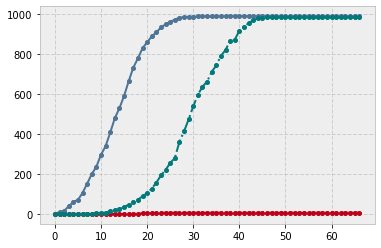

In [231]:
plt.plot(data.T);

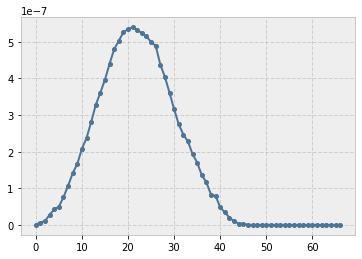

In [232]:
plt.plot(data_normed_only_conf);

# SEIR ans SIR-X model

In [215]:
@jit
def base_seir_model(init_vals, dt, N, params):
    res = np.empty((N, 4), dtype=np.float64)
    S = res[:, 0]
    E = res[:, 1]
    I = res[:, 2]
    R = res[:, 3]
    S[0], E[0], I[0], R[0] = init_vals
    alpha, beta, gamma = params
    for i in range(1, N):
        S[i] = S[i-1] - (beta*S[i-1]*I[i-1])*dt
        E[i] = E[i-1] + (beta*S[i-1]*I[i-1] - alpha*E[i-1])*dt
        I[i] = I[i-1] + (alpha*E[i-1] - gamma*I[i-1])*dt
        R[i] = R[i-1] + (gamma*I[i-1])*dt

    #print(I)
    return res


def seir_rhs(y, t, alpha, beta, gamma):
    S, E, I, R = y
    return [-beta*S*I, beta*S*I - alpha*E, alpha*E - gamma*I, gamma*I]

def base_seir_model_odeint(init_vals, dt, N, params):
    t_max = N*dt
    t = np.linspace(0, t_max, N)
    sol = odeint(seir_rhs, init_vals, t, args=params)
    #return sol[::int(1/dt)]
    return sol


def sirx_rhs(x, t, alpha, beta, k0, k):
    S, I, X, R = x
    dsdt = -alpha*S*I - k0*S
    didt = alpha*S*I - beta*I - k0*I - k*I
    dxdt = (k0+k)*I
    dRdt = k0*S + beta*I
    return np.array([dsdt, didt, dxdt, dRdt])

def base_sirx_model_odeint(init_vals, dt, N, params):
    t_max = N*dt
    t = np.linspace(0, t_max, N)
    sol = odeint(sirx_rhs, init_vals, t, args=params)
    return sol



# SIR Model (not working)
@jit
def base_sirf_model(init_vals, dt, N, params):
    res = np.empty((N, 3), dtype=np.float64)
    y = res[:, 0]
    E = res[:, 1]
    I = res[:, 2]
    R = res[:, 3]
    S[0], E[0], I[0], R[0] = init_vals
    alpha, beta, gamma = params
    for i in range(1, N):
        S[i] = S[i-1] - (beta*S[i-1]*I[i-1])*dt
        E[i] = E[i-1] + (beta*S[i-1]*I[i-1] - alpha*E[i-1])*dt
        I[i] = I[i-1] + (alpha*E[i-1] - gamma*I[i-1])*dt
        R[i] = R[i-1] + (gamma*I[i-1])*dt

    return res



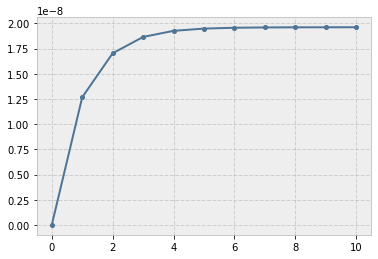

In [193]:
# Test
t_max = 10
dt = .1
N = int(t_max / dt) + 1
t = np.linspace(0, t_max, N)

Nn = 1000000
init_vals = 1 - 1/Nn, 1/Nn, 0, 0
alpha = 0.02
beta = 1
gamma = 1
params = alpha, beta, gamma
# Run simulation
results = base_seir_model_odeint(init_vals, dt, N, params)

#plt.plot(t, results[:, 2]);
plt.plot(results[:, 2]);

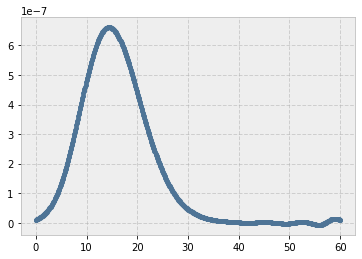

In [224]:
# Test SIRX
t_max = 60
dt = .1
N = int(t_max / dt) + 1
t = np.linspace(0, t_max, N)

x0 = np.array([1.0, 1e-8, 0.0, 0.0])
beta = 0.38 #d^{-1}
R0 = 3.07
alpha = R0*beta
k0 = 6e-2
k = 5e-2

params = alpha, beta, k0, k

results = base_sirx_model_odeint(x0, dt, N, params)

plt.plot(t, results[:, 1]);
#plt.plot(results[:, 1]);

In [213]:
params

(1.1665999999999999, 0.38, 0.06, 0.05)

# Apply MCMC

## SIR-X

In [236]:
# SIRX

alpha_MC = pm.Normal("alpha_MC", 1.1, 0.2)
beta_MC  = pm.Normal("beta_MC", 0.38, 0.05)
k0_MC    = pm.Normal("k0_MC", 0.06, 0.01)
k_MC     = pm.Normal("k_MC", 0.05, 0.01)
I0_MC    = pm.Exponential("I0_MC", 1e-6)



true_vals = data_normed[0]

vals = []

@pm.deterministic
def obs(alpha_MC=alpha_MC, beta_MC=beta_MC, k0_MC=k0_MC, k_MC=k_MC, I0_MC=I0_MC):
        #global vals
        cf = 4
        dt = 1.0/cf
        N = len(true_vals)
        num = (N-1)*cf + 1
        res = base_sirx_model_odeint((1, I0_MC, 0, 0), dt, num, (alpha_MC, beta_MC, k0_MC, k_MC))
        rr = res.T[2][::cf]
        #print(rr)
        #vals.append(rr)
        return rr
    
# infected (we know them)
#I_MC = pm.Exponential("I_MC", obs, observed=True, value=data_normed[0])
I_MC = pm.Normal("I_MC", obs, 1e-8, observed=True, value=true_vals)

mcmc = pm.MCMC([alpha_MC, beta_MC, k0_MC, k_MC, I0_MC, I_MC])
#mcmc.sample(100000, 10000, 100)
#mcmc.sample(10)
#mcmc.sample(1000, 100, 10)
mcmc.sample(50000, 5000, 10)

 [                  0%                  ] 236 of 50000 complete in 25.3 sec

/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: overflow encountered in multiply
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars


 [                  0%                  ] 326 of 50000 complete in 35.3 sec

/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: overflow encountered in double_scalars
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: overflow encountered in multiply


 [                  0%                  ] 392 of 50000 complete in 49.3 sec

/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: overflow encountered in double_scalars


 [                  0%                  ] 468 of 50000 complete in 70.8 sec

/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: overflow encountered in double_scalars


 [                  0%                  ] 486 of 50000 complete in 95.4 sec

/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: overflow encountered in multiply


 [                  0%                  ] 489 of 50000 complete in 109.7 sec

/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in double_scalars


 [-----------------100%-----------------] 50001 of 50000 complete in 44501.8 sec

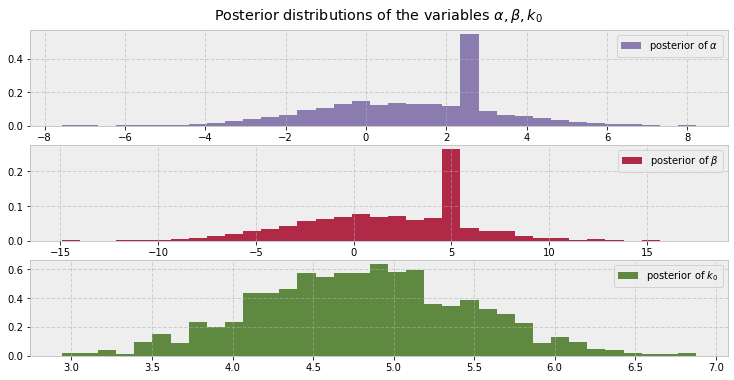

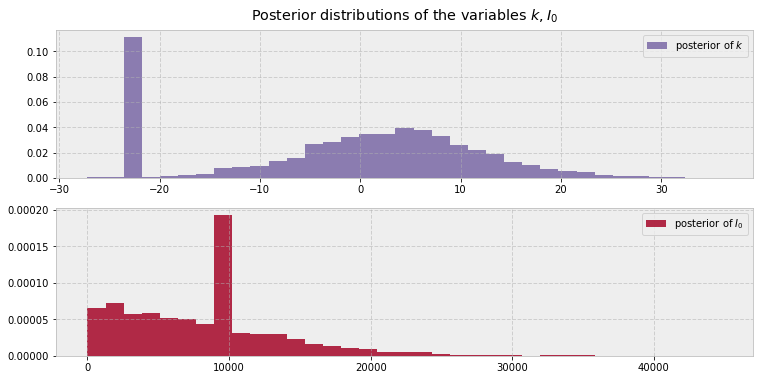

In [240]:
alpha_samples = mcmc.trace('alpha_MC')[:]
beta_samples = mcmc.trace('beta_MC')[:]
k0_samples = mcmc.trace('k0_MC')[:]
k_samples = mcmc.trace('k_MC')[:]
I0_samples = mcmc.trace('I0_MC')[:]



plt.figure(figsize=(12.5, 6))

# histogram of the samples:
plt.subplot(311)
plt.title(r"Posterior distributions of the variables $\alpha, \beta, k_0$")
plt.hist(alpha_samples, histtype='stepfilled', bins=35, alpha=0.85,
         label=r"posterior of $\alpha$", color="#7A68A6", density=True)
plt.legend()

plt.subplot(312)
plt.hist(beta_samples, histtype='stepfilled', bins=35, alpha=0.85,
         label=r"posterior of $\beta$", color="#A60628", density=True)
plt.legend();

plt.subplot(313)
plt.hist(gamma_samples, histtype='stepfilled', bins=35, alpha=0.85,
         label=r"posterior of $k_0$", color="#467821", density=True)
plt.legend();


plt.figure(figsize=(12.5, 6))

plt.subplot(211)
plt.title(r"Posterior distributions of the variables $k, I_0$")
plt.hist(k_samples, histtype='stepfilled', bins=35, alpha=0.85,
         label=r"posterior of $k$", color="#7A68A6", density=True)
plt.legend()

plt.subplot(212)
plt.hist(I0_samples, histtype='stepfilled', bins=35, alpha=0.85,
         label=r"posterior of $I_0$", color="#A60628", density=True)
plt.legend();


## SEIR

In [233]:
# SEIR

"""
alpha_MC = pm.Exponential("alpha_MC", 1./0.2)
beta_MC  = pm.Exponential("beta_MC", 1./0.5)
gamma_MC = pm.Exponential("gamma_MC", 1./0.4)
Nn_MC    = pm.Exponential("Nn_MC", 1./10000)
"""


"""
alpha_MC = pm.Uniform("alpha_MC", 0.0002, 2)
beta_MC  = pm.Uniform("beta_MC", 0.001, 2)
gamma_MC = pm.Uniform("gamma_MC", 0.001, 2)
Nn_MC    = pm.Uniform("Nn_MC", 1000, 1e6)
"""

alpha_MC = pm.Normal("alpha_MC", 5, 2)
beta_MC  = pm.Normal("beta_MC", 5, 2)
gamma_MC = pm.Normal("gamma_MC", 5, 2)
Nn_MC    = pm.Exponential("Nn_MC", 1./10000)



vals = []

@pm.deterministic
def obs(alpha_MC=alpha_MC, beta_MC=beta_MC, gamma_MC=gamma_MC, Nn_MC=Nn_MC):
        global vals
        cf = 4
        dt = 1.0/cf
        N = len(data_normed_only_conf)
        num = (N-1)*cf + 1
#        res = base_seir_model_odeint((1 - 1/Nn_MC, 1/Nn_MC, 0, 0), dt, num, (alpha_MC, beta_MC, gamma_MC))
        res = base_seir_model((1 - 1/Nn_MC, 1/Nn_MC, 0, 0), dt, num, (alpha_MC, beta_MC, gamma_MC))
        rr = res.T[2][::cf]
        #print(rr)
        vals.append(rr)
        return rr
    
# infected (we know them)
#I_MC = pm.Exponential("I_MC", obs, observed=True, value=data_normed[0])
I_MC = pm.Normal("I_MC", obs, [1e-8]*len(data_normed_only_conf), observed=True, value=data_normed_only_conf)

#model = pm.Model([alpha_MC, beta_MC, gamma_MC, Nn_MC, I_MC])
#mcmc = pm.MCMC(model)
mcmc = pm.MCMC([alpha_MC, beta_MC, gamma_MC, Nn_MC, I_MC])
mcmc.sample(100000, 10000, 100)
#mcmc.sample(10)
#mcmc.sample(1000, 100, 10)
#mcmc.sample(10000, 1000, 10)


 [-----------------100%-----------------] 100000 of 100000 complete in 23.6 sec

In [237]:
alpha_samples = mcmc.trace('alpha_MC')[:]
beta_samples = mcmc.trace('beta_MC')[:]
gamma_samples = mcmc.trace('gamma_MC')[:]


plt.figure(figsize=(12.5, 6))

# histogram of the samples:
plt.subplot(311)
plt.title(r"Posterior distributions of the variables $\alpha, \beta, \gamma$")
plt.hist(alpha_samples, histtype='stepfilled', bins=35, alpha=0.85,
         label=r"posterior of $\alpha$", color="#7A68A6", density=True)
plt.legend()

plt.subplot(312)
plt.hist(beta_samples, histtype='stepfilled', bins=35, alpha=0.85,
         label=r"posterior of $\beta$", color="#A60628", density=True)
plt.legend();

plt.subplot(313)
plt.hist(gamma_samples, histtype='stepfilled', bins=35, alpha=0.85,
         label=r"posterior of $\gamma$", color="#467821", density=True)
plt.legend();


KeyError: 'gamma_MC'

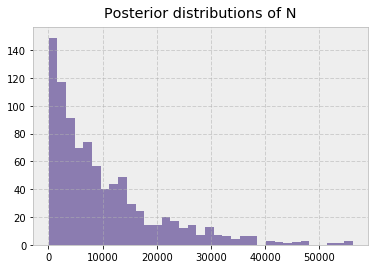

In [134]:
Nn_samples = mcmc.trace('Nn_MC')[:]
plt.title(r"Posterior distributions of N")
plt.hist(Nn_samples, histtype='stepfilled', bins=35, alpha=0.85,
         label=r"posterior of $\alpha$", color="#7A68A6");


/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: overflow encountered in double_scalars
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: overflow encountered in double_scalars


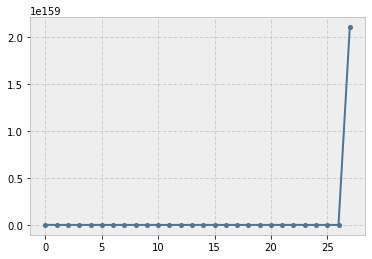

In [243]:
params = 2.5, 5, 4.8, -23, 9000
def obs(alpha_MC=alpha_MC, beta_MC=beta_MC, k0_MC=k0_MC, k_MC=k_MC, I0_MC=I0_MC):
        #global vals
        cf = 4
        dt = 1.0/cf
        N = len(data_normed_only_conf)
        num = (N-1)*cf + 1
        res = base_sirx_model_odeint((1, I0_MC, 0, 0), dt, num, (alpha_MC, beta_MC, k0_MC, k_MC))
        rr = res.T[1][::cf]
        #print(rr)
        #vals.append(rr)
        return rr
plt.plot(obs(*params))

In [11]:
# pyMC3 code
with pm.Model() as model:
    
    alpha_MC = pm.Exponential("alpha_MC", 1./3)
    beta_MC  = pm.Exponential("beta_MC", 1./3)
    gamma_MC = pm.Exponential("gamma_MC", 1./3)
    Nn_MC    = pm.Exponential("Nn_MC", 1./10000)

    #@pm.deterministic
    def obs(alpha_MC=alpha_MC, beta_MC=beta_MC, gamma_MC=gamma_MC, Nn_MC=Nn_MC):
        cf = 4
        dt = 1.0/cf
        N = data_normed.shape[1]
        num = N*cf + 1
        res = base_seir_model((1 - 1/Nn_MC, 1/Nn_MC, 0, 0), 1, num, (alpha_MC, beta_MC, gamma_MC))
        return res.T[2][::num]
    
    # indefcted (we know them)
    I_MC = pm.Categorical("I_MC", obs, observed=data[0])
    
    # Simulations
    step = pm.Metropolis()
    trace = pm.sample(10000, tune=5000,step=step)


AttributeError: __enter__